In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import openmeteo_requests
import requests_cache
from datetime import date, timedelta
import seaborn as sns
import numpy as np
import os
import sys
import pygam
import sklearn
sys.path.append("..")
from pygam import LinearGAM, f, s, te 


citing pyGAM: Servén D., Brummitt C. (2018). pyGAM: Generalized Additive Models in Python. Zenodo. DOI: 10.5281/zenodo.1208723

In [153]:
# data load 
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)

In [ ]:
# Übersicht über mstl_data Columns
mstl_data.columns.tolist()

['timestamp',
 'city',
 'counter_site',
 'longitude',
 'latitude',
 'count',
 'count_capped',
 'log_count',
 'trend',
 'seasonal_24',
 'seasonal_168',
 'seasonal_8766',
 'residual']

In [ ]:
# extrahiere benötigte Spalten für GAMS
residual_data = mstl_data[['timestamp',
 'city',
 'counter_site',
 #'longitude',
 #'latitude',
 #'count',
 #'count_capped',
 #'log_count',
 'residual']].copy()
# filtert Zeilen raus, in denen anstatt Werten die Columnnames stehen
residual_data = residual_data[residual_data['timestamp']!='timestamp']

In [189]:
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()

In [190]:
len(list(set(residual_data['id'].to_list())))

77

In [191]:
# load weather data 
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)
print(weather_data.head())
print(weather_data.isna().sum())

                        date  temperature_2m  apparent_temperature  rain  \
0  2012-12-30 23:00:00+00:00          5.8285              1.619927   0.0   
1  2012-12-31 00:00:00+00:00          5.8285              1.688656   0.0   
2  2012-12-31 01:00:00+00:00          5.9285              1.827309   0.0   
3  2012-12-31 02:00:00+00:00          5.7285              1.757791   0.0   
4  2012-12-31 03:00:00+00:00          5.4785              1.713898   0.0   

   snowfall  forecast_temperature_2m  forecast_apparent_temperature  \
0       0.0                      NaN                            NaN   
1       0.0                      NaN                            NaN   
2       0.0                      NaN                            NaN   
3       0.0                      NaN                            NaN   
4       0.0                      NaN                            NaN   

   forecast_rain  forecast_snowfall                        city  
0            NaN                NaN  Landeshauptst

In [ ]:
# merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']], right_on=['city', weather_data['date']], how='left')

print(merged_data.shape)
merged_data.isna().sum()

(3678215, 15)


timestamp                              0
key_1                                  0
city                                   0
counter_site                           0
residual                               0
id                                     0
date                               18750
temperature_2m                     18750
apparent_temperature               18750
rain                               18750
snowfall                           18750
forecast_temperature_2m          1327608
forecast_apparent_temperature    1327608
forecast_rain                    1327657
forecast_snowfall                1327657
dtype: int64

In [193]:
print(residual_data.shape)
print(merged_data.shape)
residual_data.isna().sum()

(3678215, 5)
(3678215, 15)


timestamp       0
city            0
counter_site    0
residual        0
id              0
dtype: int64

In [198]:
# Referenzzeitpunkt (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist())) 
print(ref)

# 1) Spalte vektorisert in Datetime konvertieren (einmalig)
t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce')

# 2) Differenz in Stunden berechnen (vektorisiert)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0

# => timestamp_number ist jetzt die Anzahl Stunden seit Referenzzeitpunkt

2012-12-31 23:00:00+00:00


In [199]:
y = merged_data['residual'].astype(float).values
X = merged_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).values
# drop rows with NaN values in X or y
mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
y = y[mask]
X = X[mask]

In [200]:
merged_data.isna().sum()

timestamp                              0
key_1                                  0
city                                   0
counter_site                           0
residual                               0
id                                     0
date                               18750
temperature_2m                     18750
apparent_temperature               18750
rain                               18750
snowfall                           18750
forecast_temperature_2m          1327608
forecast_apparent_temperature    1327608
forecast_rain                    1327657
forecast_snowfall                1327657
timestamp_number                       0
dtype: int64

Empfehlung von ChatGPT:
gam = LinearGAM(
    s(0, n_splines=10) +                 # timestamp_days (drift)
    f(1, lam=20) +                       # counter_site_id
    s(2, n_splines=8) +                  # temp_anom
    s(3, n_splines=6) +                  # temp_diff
    f(4) + s(5) +                        # rain
    f(6) + s(7) +                        # snow
    te(2, 5, n_splines=5)                # temp × rain
).fit(X, y)

X = [
    timestamp_days,
    counter_site_id,
    temp_anom,
    temp_diff,
    rain_bin,
    rain_log,
    snow_bin,
    snow_log
]

gam.statistics_['pseudo_r2']
gam.statistics_['AIC']

temp_anom = temperature_2m - temperature_2m.mean()
temp_diff = apparent_temperature - temperature_2m

rain_bin = (rain > 0).astype(int)
rain_log = np.log1p(rain)

snow_bin = (snowfall > 0).astype(int)
snow_log = np.log1p(snowfall)


In [201]:
gam = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
    f(1, lam=50) +                       # id
    s(2, n_splines=8) +                  # temp
    s(3) +                               # rain
    s(4) +                               # snow
    te(2, 3, n_splines=5)                # temp × rain
).fit(X, y)


In [202]:
print(gam.statistics_['pseudo_r2'])
print(gam.statistics_['AIC'])

OrderedDict([('explained_deviance', np.float64(0.05296875067989493)), ('McFadden', np.float64(0.8915546989156158)), ('McFadden_adj', np.float64(0.10831734354213729))])
1682901.8363863465


Merksatz (wichtig!)

🔹 Für Gaussian-GAMs: nur explained_deviance ernst nehmen
🔹 5 % nach MSTL = starkes Ergebnis
🔹 AIC nur zum Modellvergleich, nie absolut

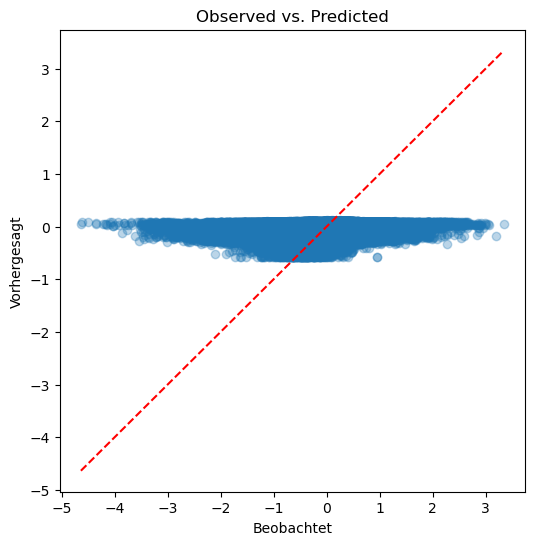

In [203]:
y_pred = gam.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Beobachtet")
plt.ylabel("Vorhergesagt")
plt.title("Observed vs. Predicted")
plt.show()

In [151]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.9328
Link Function:                     IdentityLink Log Likelihood:                               -702250.1506
Number of Samples:                      2761419 AIC:                                          1404592.1667
                                                AICc:                                         1404592.1683
                                                GCV:                                                0.0974
                                                Scale:                                               0.312
                                                Pseudo R-Squared:                                   0.0508
Feature Function                  Lam

C:\Users\johan\AppData\Local\Temp\ipykernel_29964\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
# läuft auch durch, aber ist schlecht
# gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)